In [1]:
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
from drivers.tree_builder import TreeNeo
from drivers.graph_models import TreeNode, Order, Family, graph,Kingdom,Occurrence
from drivers.graph_models import Cell,Mex4km, countObjectsOf
from drivers.graph_models import pickNode
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
import numpy as np

## Use the ggplot style
plt.style.use('ggplot')

# Extract grid or subgrid in Graph data type.
This one of the first steps into modelling Gaussian Markov Random Fields (GMRF).
1. The first step is to extract a subgrid given a polygon.
2. Extract the neighbours of the selected cells. 
3. Take the Union of that
4. Create an adjancency matrix
5. Rearrange the nodes
6. Model the GMRF

In [14]:
from sketches.models import Country
from mesh.models import MexMesh
from traversals.sampling import UniformRandomCellSample
from drivers.graph_models import Cell,Mex4km
from traversals.strategies import idsToCells,LatticeToNetworkx
import networkx as nx
Mexico = Country.objects.filter(name__contains="exico").get()
mexican_cells = MexMesh.objects.filter(cell__intersects=Mexico.geom)

In [3]:
## Custom polygon
polystr = 'POLYGON((-92.54989447928841173 16.93450143453089396,-91.70267654367958698 16.9021871200489322,-91.68015912346406537 16.28717344210308937,-92.56396786692310741 16.31959139053146757,-92.54989447928841173 16.93450143453089396))'


In [4]:
from django.contrib.gis.geos import GEOSGeometry
polygon = GEOSGeometry(polystr)
subselection_cells = MexMesh.objects.filter(cell__intersects=polygon)

![Demo Region](../../demoregionmex.png)

The grid. Esach cell corresponds to a Taxonomic Tree

In [5]:
## Example with random sample but now using the same function
# Get all cell ids
ids = list(mexican_cells.values('pk'))
CellNodeClass = Mex4km
list_of_cell_ids = ids
sample_size = 300
selection_of_cells = UniformRandomCellSample(ids,Mex4km,sample_size=sample_size,random_seed=12345,with_replacement=True)

INFO Using custom random seed of: 12345
INFO Compiling Query and asking the Graph Database


In [6]:
len(list(selection_of_cells))

299

In [7]:
## The query is lazzzy
## Takes a lot time, let's do it first in a subset
#mexids = list(mexican_cells.values('pk'))
#list_of_mexcell_ids = map(lambda dic : dic['pk'], ids)
#%time all_cells = idsToCells(list_of_mexcell_ids)
#%time all_cells = list(all_cells)

In [8]:
# Get all cell ids
ids = list(subselection_cells.values('pk'))
CellNodeClass = Mex4km
list_of_cell_ids = map(lambda dic : dic['pk'], ids)
selection = idsToCells(list_of_cell_ids)
%time ll = list(selection)

INFO Compiling Query and asking the Graph Database


CPU times: user 3.38 s, sys: 96 ms, total: 3.47 s
Wall time: 6.18 s


In [9]:
c = ll[0]

In [10]:
c.getNeighbours()

[< Cell-mex4km id = 258525 >,
 < Cell-mex4km id = 258288 >,
 < Cell-mex4km id = 258286 >,
 < Cell-mex4km id = 258047 >]

In [12]:
lattice = LatticeToNetworkx(ll)

In [15]:
M = nx.adjacency_matrix(lattice).toarray()

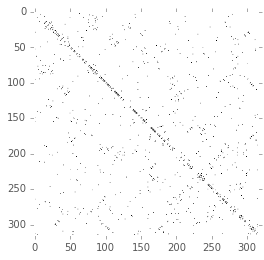

In [16]:
plt.imshow(M,cmap=plt.cm.Greys)

In [12]:
node_edges = zip(ll,map(lambda cell : cell.getNeighbours(),ll))

In [13]:
node_edges[0]

(< Cell-mex4km id = 258287 >,
 [< Cell-mex4km id = 258525 >,
  < Cell-mex4km id = 258288 >,
  < Cell-mex4km id = 258286 >,
  < Cell-mex4km id = 258047 >])

In [26]:
import networkx as nt
G =nt.Graph()

In [31]:
def createLattice(node_edge_list):
    G = nt.Graph()
    t = map(lambda (center, neighbours) : map(lambda n : G.add_edge(center,n),neighbours),node_edge_list)
    return G
    
    

In [32]:
ttt = createLattice(node_edges)

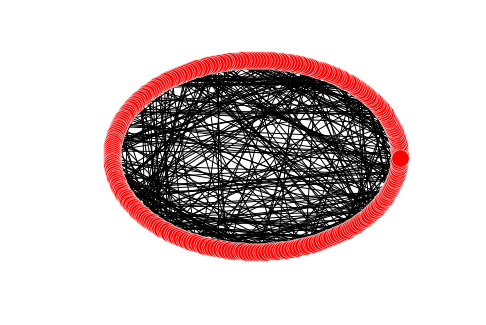

In [34]:
nt.draw_circular(ttt)

In [45]:
M = nt.adjacency_matrix(ttt).toarray()

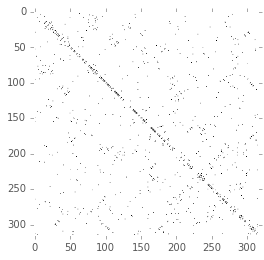

In [46]:
plt.imshow(M,cmap=plt.cm.Greys)

In [47]:
import numpy as np

In [55]:
nM = M + (30*np.eye(M.shape[0]))

In [56]:
T = np.linalg.cholesky(nM)

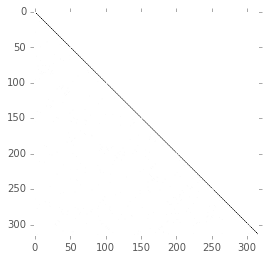

In [58]:
plt.imshow(T,cmap=plt.cm.Greys)

In [59]:
from scipy.stats import multivariate_normal

In [60]:
Z = multivariate_normal(cov=nM)


In [62]:
zz= Z.rvs()

In [71]:
len(zz)

315

In [72]:
17*17

289